In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

BASE_DIR = Path("..")
PRUNED_FILE = BASE_DIR / "data" / "intermediate_pruned.parquet"

print("=" * 80)
print("COMPREHENSIVE PRUNED DATASET ANALYSIS")
print("=" * 80)

COMPREHENSIVE PRUNED DATASET ANALYSIS


In [20]:
print("\nLoading pruned parquet file...\n")

df_full = pd.read_parquet(PRUNED_FILE)

print(f"File: intermediate_pruned.parquet")
print(f"Total loaded: {len(df_full)} rows")
print(f"Columns: {list(df_full.columns)}")
print(f"Memory usage: {df_full.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nDataset Info:")
print(f'Unique samples: {df_full["sample_id"].nunique()}')
print(f'Unique params: {df_full["param_id"].nunique()}')
print(f'Image shape (first): {df_full["image_shape"].iloc[0]}')


Loading pruned parquet file...

File: intermediate_pruned.parquet
Total loaded: 8235 rows
Columns: ['sample_id', 'param_id', 'image_compressed', 'image_shape', 'input_params', 'microstructure_outputs', 'performance_outputs']
Memory usage: 1667.1 MB

Dataset Info:
Unique samples: 85
Unique params: 100
Image shape (first): [128 128 128]


In [ ]:
# Feature definitions - UPDATED to match actual structure
INPUT_FEATURES = [
    "input_SEI kinetic rate constant [m.s-1]",
    "input_Electrolyte diffusivity [m2.s-1]",
    "input_Initial concentration in electrolyte [mol.m-3]",
    "input_Separator porosity",
    "input_Positive particle radius [m]",
    "input_Negative particle radius [m]",
    "input_Positive electrode thickness [m]",
    "input_Negative electrode thickness [m]",
    "input_Outer SEI solvent diffusivity [m2.s-1]",
    "input_Dead lithium decay constant [s-1]",
    "input_Lithium plating kinetic rate constant [m.s-1]",
    "input_Negative electrode LAM constant proportional term [s-1]",
    "input_Negative electrode cracking rate",
    "input_Outer SEI partial molar volume [m3.mol-1]",
    "input_SEI growth activation energy [J.mol-1]",
]

MICROSTRUCTURE_FEATURES = [
    "D_eff",
    "porosity_measured",
    "tau_factor",
    "bruggeman_derived",
]

PERFORMANCE_FEATURES = [
    "projected_cycle_life",
    "capacity_fade_rate",
    "internal_resistance",
    "nominal_capacity",
    "energy_density",
]

# Expand input params
input_arrays = np.array(df_full["input_params"].tolist())
df_inputs = pd.DataFrame(input_arrays, columns=INPUT_FEATURES)

# Expand microstructure outputs
micro_arrays = np.array(df_full["microstructure_outputs"].tolist())
df_micro = pd.DataFrame(micro_arrays, columns=MICROSTRUCTURE_FEATURES)

# Expand performance outputs
perf_arrays = np.array(df_full["performance_outputs"].tolist())
df_perf = pd.DataFrame(perf_arrays, columns=PERFORMANCE_FEATURES)

# Combine all
df_expanded = pd.concat(
    [
        df_full[["sample_id", "param_id"]].reset_index(drop=True),
        df_inputs,
        df_micro,
        df_perf,
    ],
    axis=1,
)

print(f"\n{'='*80}")
print(f"EXPANDED DATASET")
print(f"{'='*80}")
print(f"   Shape: {df_expanded.shape}")
print(f"   Total columns: {len(df_expanded.columns)}")
print(f"   Input features: {len(INPUT_FEATURES)}")
print(f"   Microstructure features: {len(MICROSTRUCTURE_FEATURES)}")
print(f"   Performance features: {len(PERFORMANCE_FEATURES)}")
print(f"{'='*80}\n")


EXPANDED DATASET
   Shape: (8235, 26)
   Total columns: 26
   Input features: 15
   Microstructure features: 4
   Performance features: 5



In [22]:
# Calculate statistics for input features
input_stats = df_inputs.describe().T
input_stats["missing"] = df_inputs.isnull().sum()
input_stats["missing_pct"] = (input_stats["missing"] / len(df_inputs) * 100).round(2)

cols = [
    "count",
    "mean",
    "std",
    "min",
    "25%",
    "50%",
    "75%",
    "max",
    "missing",
    "missing_pct",
]
input_stats = input_stats[cols]

print(input_stats.to_string())

# Check for missing and constant features
missing_features = input_stats[input_stats["missing"] > 0]
constant_features = input_stats[input_stats["std"] == 0]

print("\nMissing features:")
print(missing_features[["missing", "missing_pct"]] if len(missing_features) else "None")

print("\nConstant features:")
print(constant_features[["mean"]] if len(constant_features) else "None")

                                                                count          mean           std           min           25%           50%           75%           max  missing  missing_pct
input_SEI kinetic rate constant [m.s-1]                        8235.0  4.809549e-14  3.974297e-14  1.000000e-14  1.000000e-14  2.970000e-14  1.000000e-13  1.000000e-13        0          0.0
input_Electrolyte diffusivity [m2.s-1]                         8235.0  3.018600e-10  5.834427e-11  2.000000e-10  2.520000e-10  3.060000e-10  3.540000e-10  3.980000e-10        0          0.0
input_Initial concentration in electrolyte [mol.m-3]           8235.0  1.000000e+03  0.000000e+00  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03        0          0.0
input_Separator porosity                                       8235.0  5.848634e-01  2.802273e-02  5.380924e-01  5.587957e-01  5.823130e-01  6.076321e-01  6.363797e-01        0          0.0
input_Positive particle radius [m]                

In [23]:
# Calculate statistics for microstructure features
micro_stats = df_micro.describe().T
micro_stats["missing"] = df_micro.isnull().sum()
micro_stats["missing_pct"] = (micro_stats["missing"] / len(df_micro) * 100).round(2)
micro_stats = micro_stats[cols]

print(micro_stats.to_string())

                    count      mean       std       min       25%       50%       75%       max  missing  missing_pct
D_eff              8235.0  0.186293  0.076387  0.044254  0.125497  0.174813  0.246265  0.365708        0          0.0
porosity_measured  8235.0  0.495234  0.067839  0.333288  0.441679  0.488890  0.544718  0.652044        0          0.0
tau_factor         8235.0  3.091986  1.212457  1.553926  2.310864  2.805653  3.598821  7.531231        0          0.0
bruggeman_derived  8235.0  1.599370  0.005769  1.546536  1.600000  1.600000  1.600000  1.600000        0          0.0


In [24]:
print(f"\n{'='*80}")
print(f"PERFORMANCE FEATURES STATISTICS")
print(f"{'='*80}\n")

# Calculate statistics for performance features
perf_stats = df_perf.describe().T
perf_stats["missing"] = df_perf.isnull().sum()
perf_stats["missing_pct"] = (perf_stats["missing"] / len(df_perf) * 100).round(2)
perf_stats = perf_stats[cols]

print(perf_stats.to_string())

# Specific statistics for each performance feature
print(f"\n{'-'*80}")
print("DETAILED PERFORMANCE METRICS")
print(f"{'-'*80}")

for feat in PERFORMANCE_FEATURES:
    data = df_perf[feat].dropna()
    if len(data) > 0:
        print(f"\n{feat}:")
        print(f"   Count: {len(data):,}")
        print(f"   Mean: {data.mean():.4f}")
        print(f"   Std: {data.std():.4f}")
        print(f"   Min: {data.min():.4f}")
        print(f"   Max: {data.max():.4f}")
        print(
            f"   Missing: {df_perf[feat].isnull().sum():,} ({df_perf[feat].isnull().sum()/len(df_perf)*100:.2f}%)"
        )
    else:
        print(f"\n{feat}: No data available")


PERFORMANCE FEATURES STATISTICS

                       count       mean        std        min        25%        50%        75%        max  missing  missing_pct
projected_cycle_life  8235.0  42.184335  19.676909  13.000000  24.000000  36.000000  62.000000  78.000000        0          0.0
capacity_fade_rate    8235.0   0.027198   0.012895   0.007221   0.015906   0.024823   0.036370   0.064081        0          0.0
internal_resistance   8235.0   0.101446   0.004313   0.088297   0.098036   0.101470   0.104587   0.111489        0          0.0
nominal_capacity      8235.0   5.295704   0.873085   2.963431   4.648703   5.287941   5.950251   7.853955        0          0.0
energy_density        8235.0   3.883960   0.026755   3.806731   3.865069   3.883158   3.901776   3.970753        0          0.0

--------------------------------------------------------------------------------
DETAILED PERFORMANCE METRICS
--------------------------------------------------------------------------------

proje

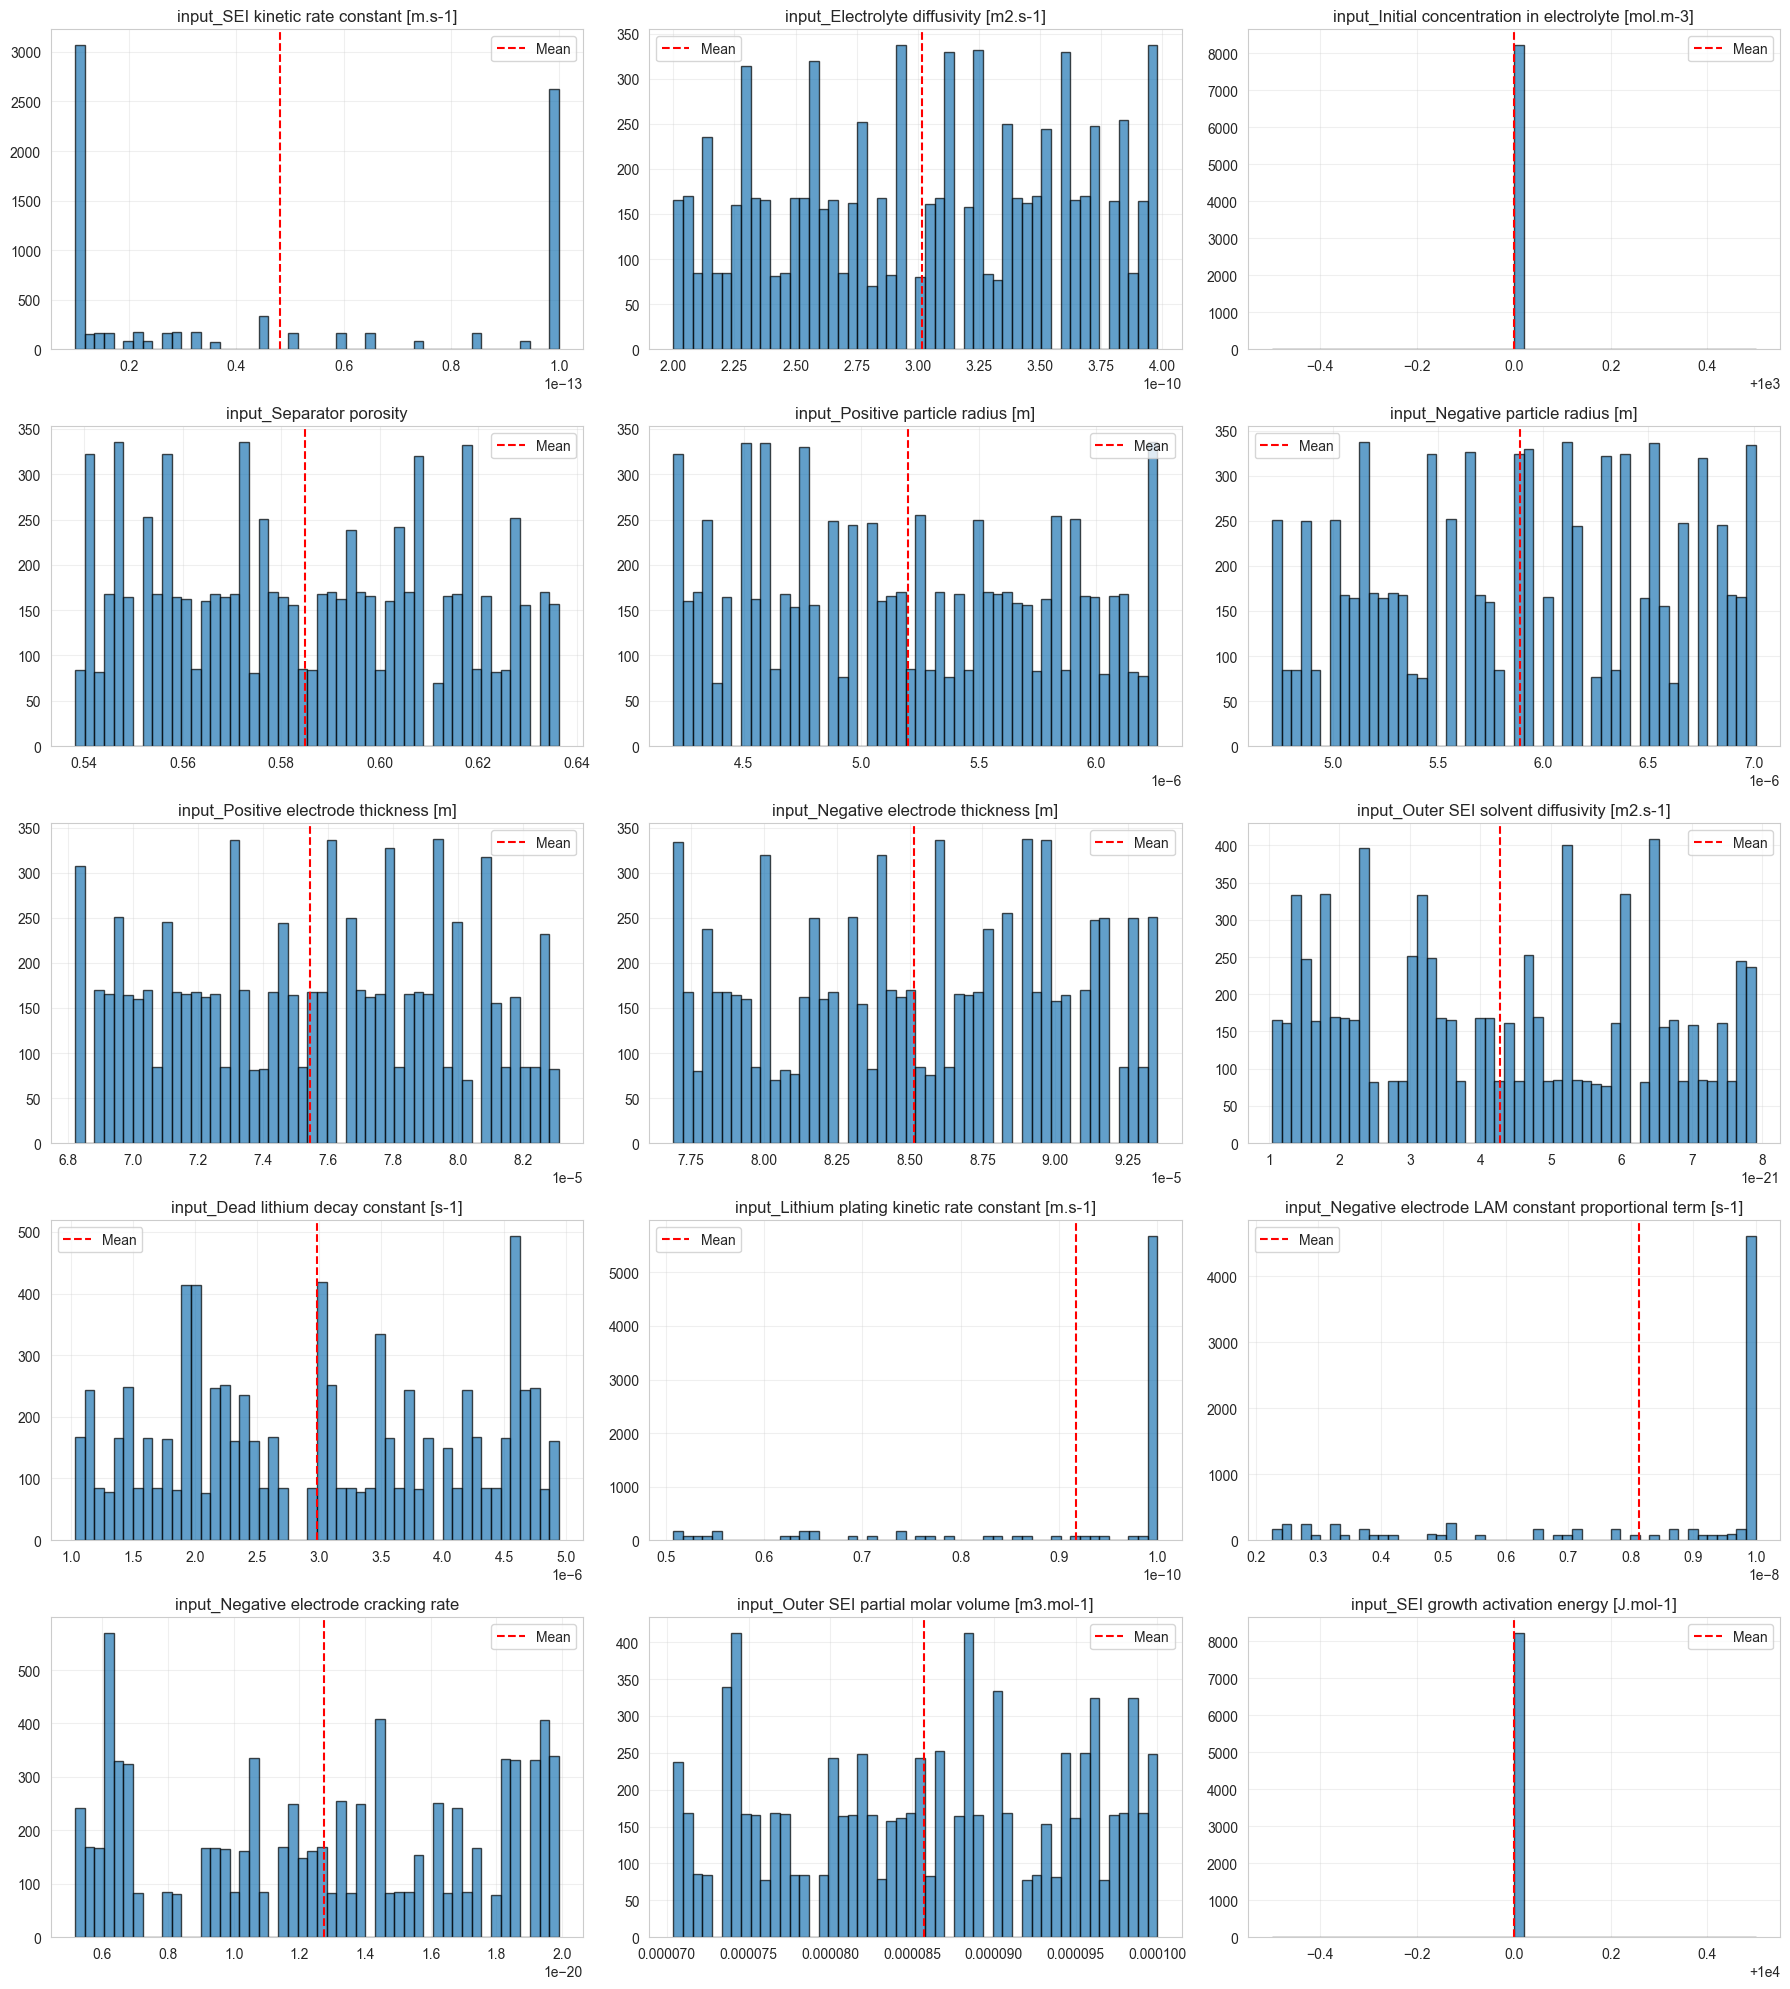

In [25]:
n_features = len(INPUT_FEATURES)
ncols = 3
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(data.mean(), linestyle="--", color="red", label="Mean")
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)
    ax.legend()

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

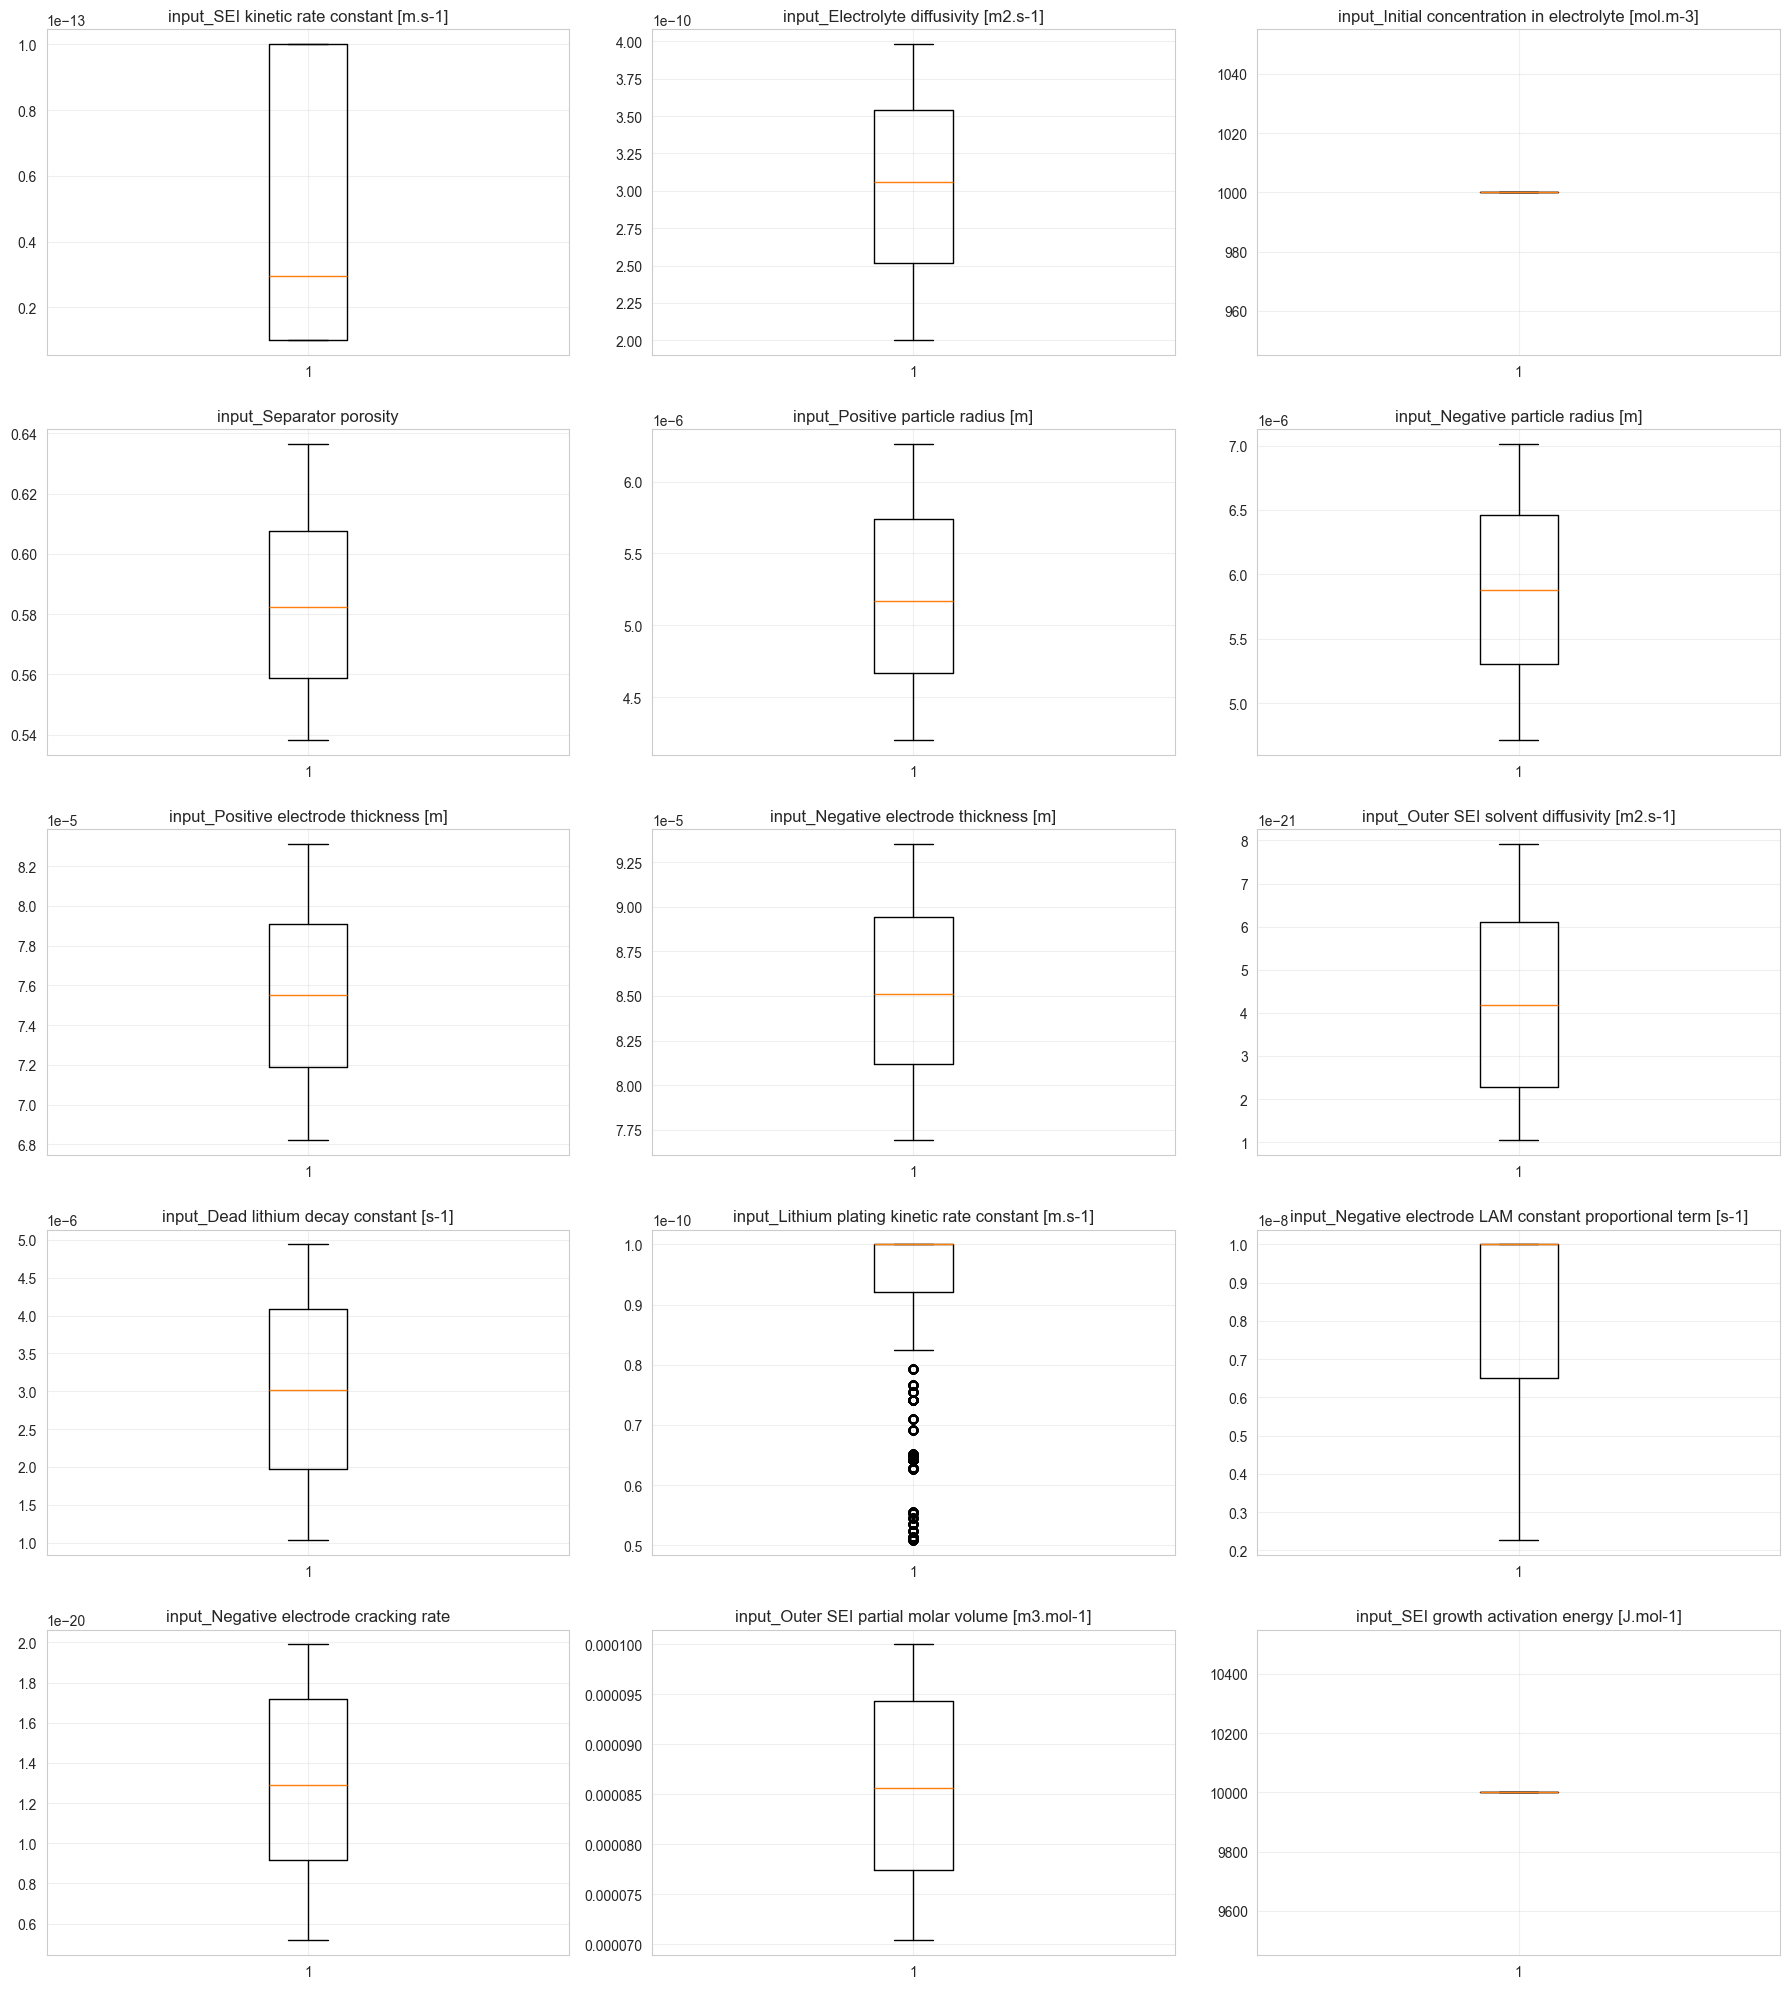

In [26]:
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.boxplot(data, vert=True)
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

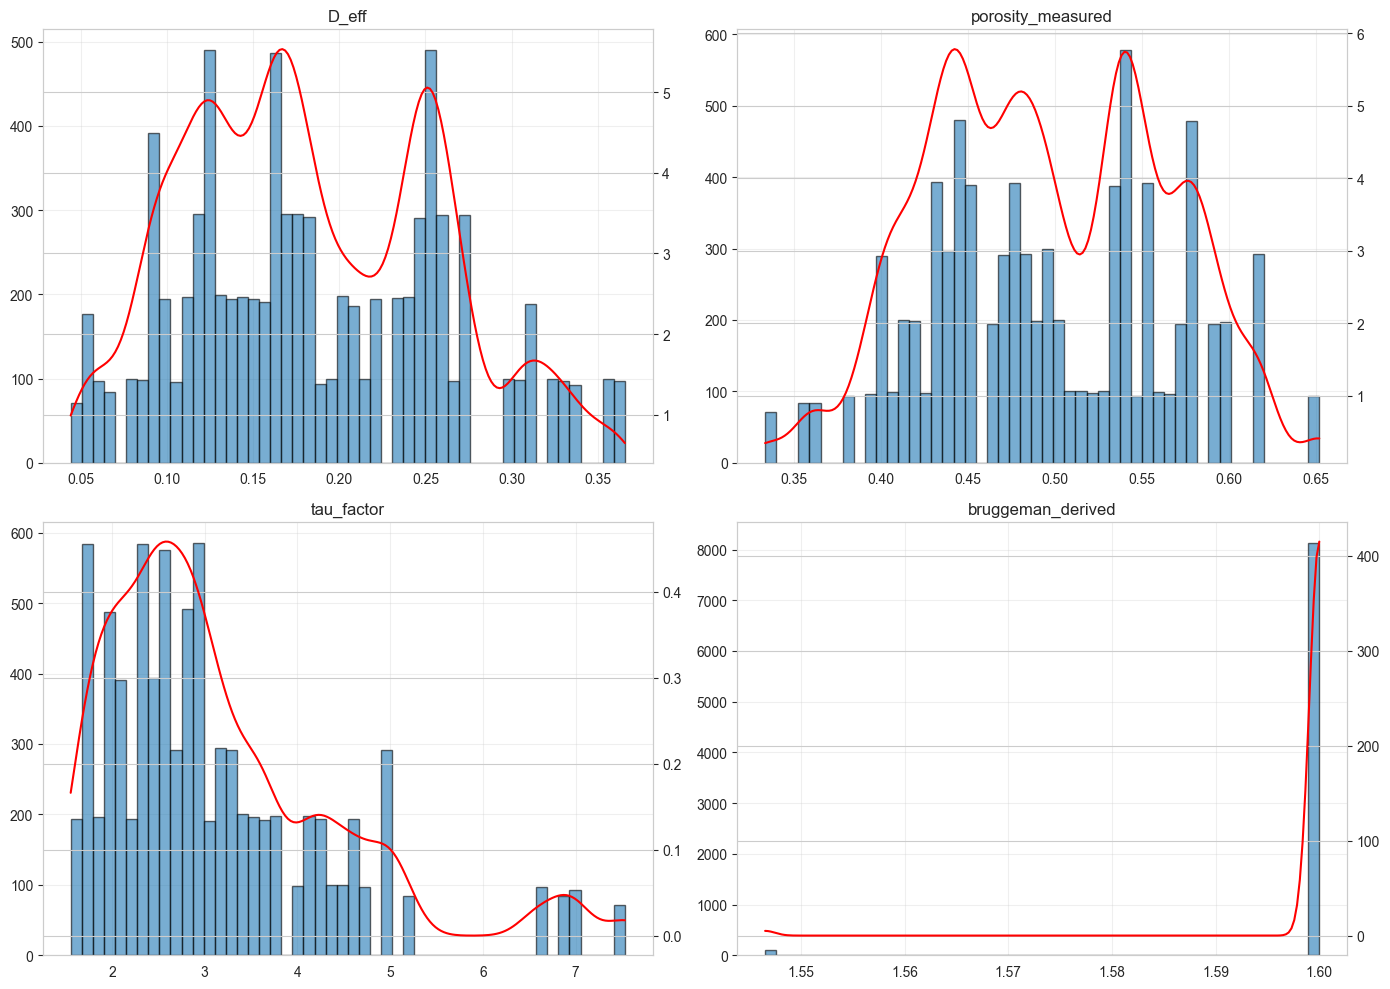

In [27]:
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feat in enumerate(MICROSTRUCTURE_FEATURES):
    data = df_micro[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.6, edgecolor="black", label="Data")

    # Add KDE
    density = stats.gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    ax2 = ax.twinx()
    ax2.plot(xs, density(xs), "r-", label="KDE")

    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

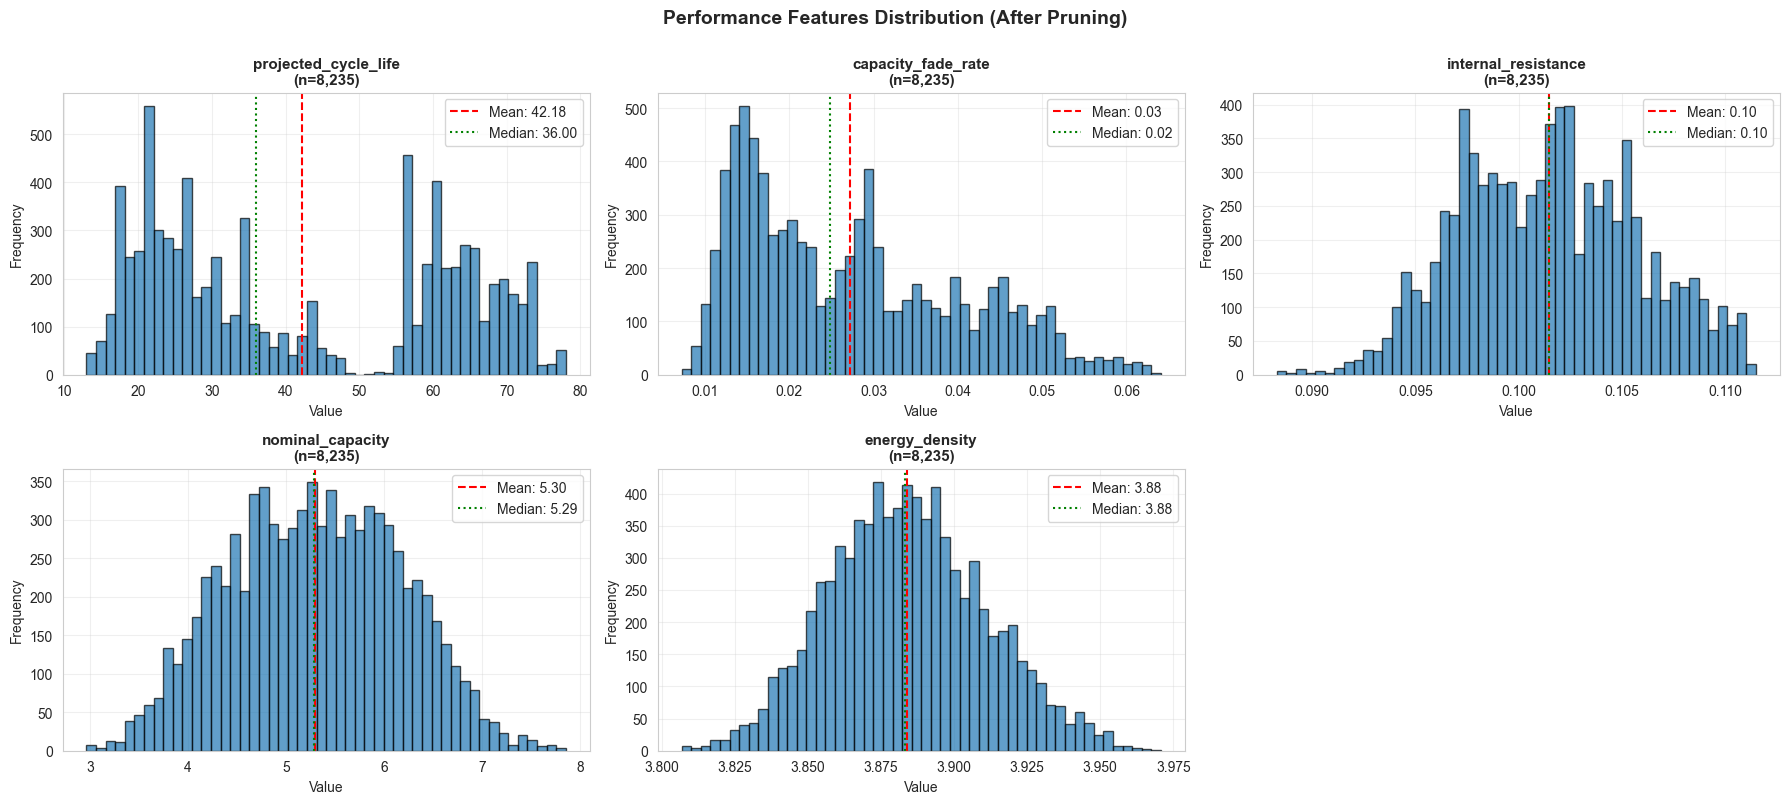

In [28]:
# %%
n_perf = len(PERFORMANCE_FEATURES)
ncols = 3
nrows = (n_perf + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

for idx, feat in enumerate(PERFORMANCE_FEATURES):
    data = df_perf[feat].dropna()
    ax = axes[idx]

    if len(data) > 0:
        ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
        ax.axvline(
            data.mean(), linestyle="--", color="red", label=f"Mean: {data.mean():.2f}"
        )
        ax.axvline(
            data.median(),
            linestyle=":",
            color="green",
            label=f"Median: {data.median():.2f}",
        )
        ax.set_title(f"{feat}\n(n={len(data):,})", fontsize=11, fontweight="bold")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=14)
        ax.set_title(feat, fontsize=11, fontweight="bold")

for idx in range(n_perf, len(axes)):
    axes[idx].axis("off")

plt.suptitle(
    "Performance Features Distribution (After Pruning)",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.show()

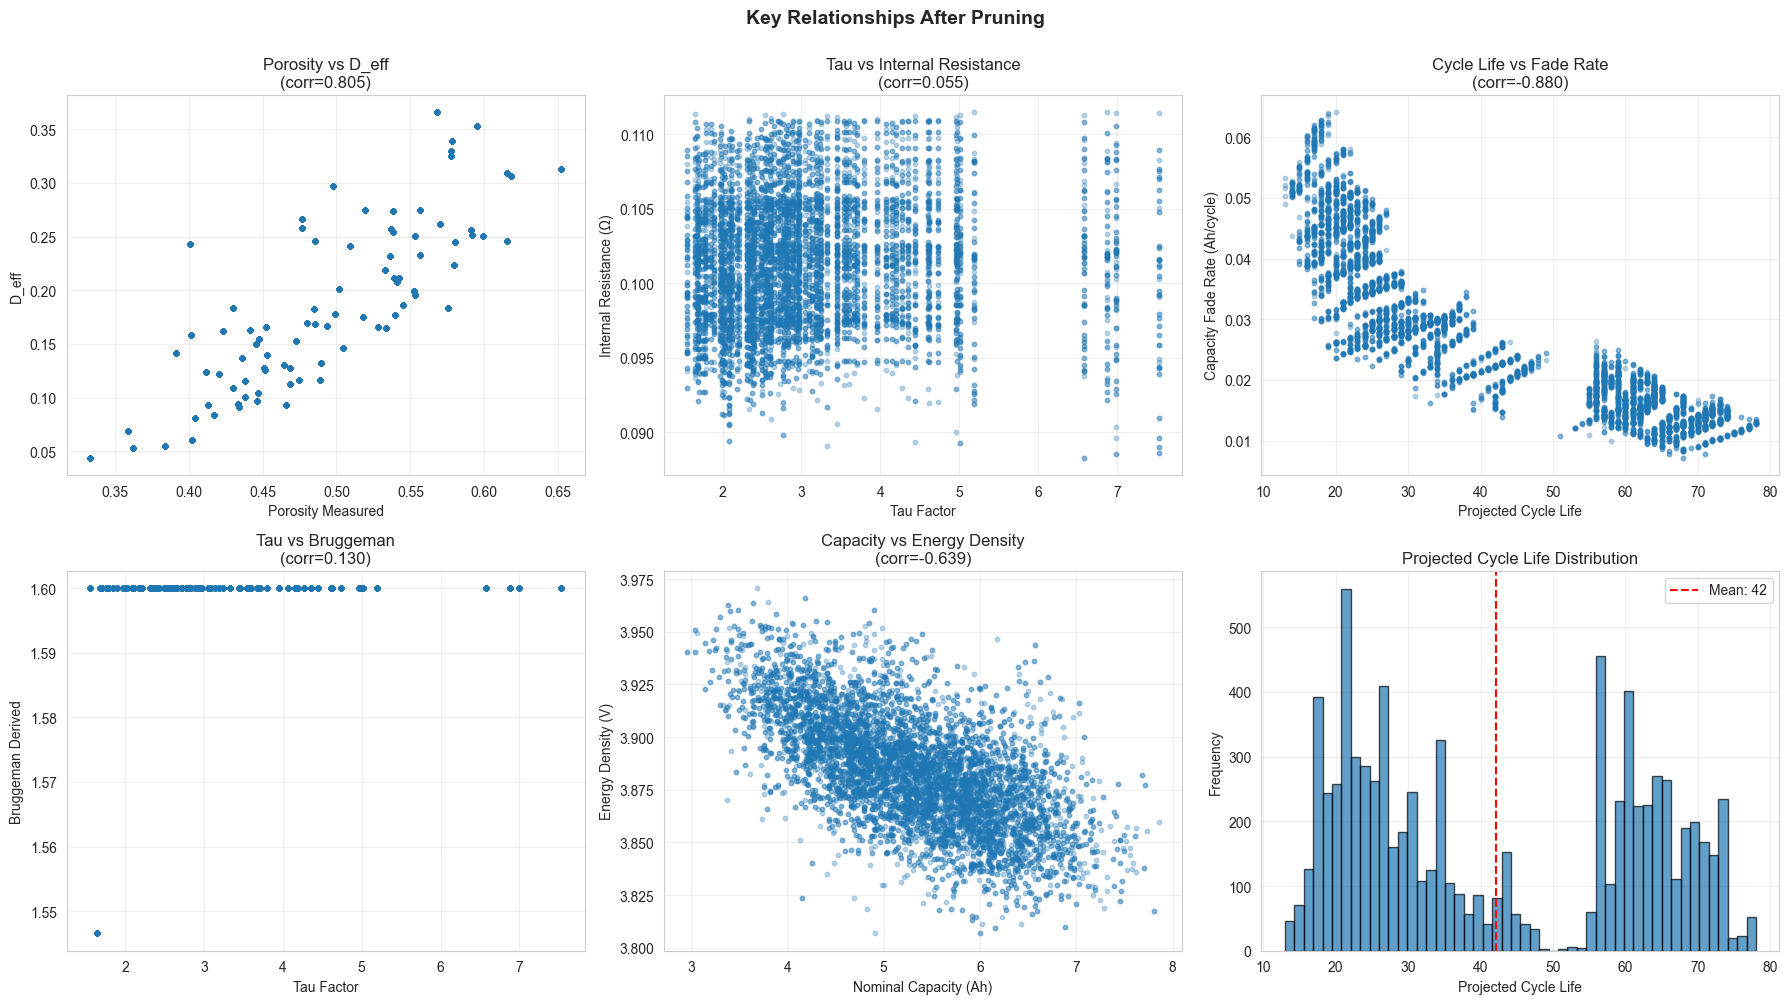

In [29]:
# %%
# Plot key relationships - UPDATED for new features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Porosity vs D_eff
ax = axes[0, 0]
valid_data = df_expanded[["porosity_measured", "D_eff"]].dropna()
ax.scatter(valid_data["porosity_measured"], valid_data["D_eff"], alpha=0.3, s=10)
corr = valid_data["porosity_measured"].corr(valid_data["D_eff"])
ax.set_xlabel("Porosity Measured")
ax.set_ylabel("D_eff")
ax.set_title(f"Porosity vs D_eff\n(corr={corr:.3f})")
ax.grid(True, alpha=0.3)

# Plot 2: Tau factor vs Internal Resistance
ax = axes[0, 1]
valid_data = df_expanded[["tau_factor", "internal_resistance"]].dropna()
if len(valid_data) > 0:
    ax.scatter(
        valid_data["tau_factor"], valid_data["internal_resistance"], alpha=0.3, s=10
    )
    corr = valid_data["tau_factor"].corr(valid_data["internal_resistance"])
    ax.set_xlabel("Tau Factor")
    ax.set_ylabel("Internal Resistance (Ω)")
    ax.set_title(f"Tau vs Internal Resistance\n(corr={corr:.3f})")
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, "No data", ha="center", va="center")
    ax.set_title("Tau vs Internal Resistance")

# Plot 3: Projected Cycle Life vs Capacity Fade Rate
ax = axes[0, 2]
valid_data = df_expanded[["projected_cycle_life", "capacity_fade_rate"]].dropna()
if len(valid_data) > 0:
    ax.scatter(
        valid_data["projected_cycle_life"],
        valid_data["capacity_fade_rate"],
        alpha=0.3,
        s=10,
    )
    corr = valid_data["projected_cycle_life"].corr(valid_data["capacity_fade_rate"])
    ax.set_xlabel("Projected Cycle Life")
    ax.set_ylabel("Capacity Fade Rate (Ah/cycle)")
    ax.set_title(f"Cycle Life vs Fade Rate\n(corr={corr:.3f})")
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, "No data", ha="center", va="center")
    ax.set_title("Cycle Life vs Fade Rate")

# Plot 4: Bruggeman derived vs tau factor
ax = axes[1, 0]
valid_data = df_expanded[["tau_factor", "bruggeman_derived"]].dropna()
ax.scatter(valid_data["tau_factor"], valid_data["bruggeman_derived"], alpha=0.3, s=10)
corr = valid_data["tau_factor"].corr(valid_data["bruggeman_derived"])
ax.set_xlabel("Tau Factor")
ax.set_ylabel("Bruggeman Derived")
ax.set_title(f"Tau vs Bruggeman\n(corr={corr:.3f})")
ax.grid(True, alpha=0.3)

# Plot 5: Nominal Capacity vs Energy Density
ax = axes[1, 1]
valid_data = df_expanded[["nominal_capacity", "energy_density"]].dropna()
if len(valid_data) > 0:
    ax.scatter(
        valid_data["nominal_capacity"], valid_data["energy_density"], alpha=0.3, s=10
    )
    corr = valid_data["nominal_capacity"].corr(valid_data["energy_density"])
    ax.set_xlabel("Nominal Capacity (Ah)")
    ax.set_ylabel("Energy Density (V)")
    ax.set_title(f"Capacity vs Energy Density\n(corr={corr:.3f})")
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, "No data", ha="center", va="center")
    ax.set_title("Capacity vs Energy Density")

# Plot 6: Projected Cycle Life distribution
ax = axes[1, 2]
cycle_data = df_expanded["projected_cycle_life"].dropna()
if len(cycle_data) > 0:
    ax.hist(cycle_data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(
        cycle_data.mean(),
        color="red",
        linestyle="--",
        label=f"Mean: {cycle_data.mean():.0f}",
    )
    ax.set_xlabel("Projected Cycle Life")
    ax.set_ylabel("Frequency")
    ax.set_title("Projected Cycle Life Distribution")
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, "No data", ha="center", va="center")
    ax.set_title("Projected Cycle Life Distribution")

plt.suptitle("Key Relationships After Pruning", fontsize=14, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

In [30]:
print(f"\n{'='*80}")
print(f"PRUNING IMPACT ANALYSIS")
print(f"{'='*80}\n")

# Compare with intermediate dataset if available
intermediate_summary_file = BASE_DIR / "data" / "intermediate_analysis_summary.json"

if intermediate_summary_file.exists():
    with open(intermediate_summary_file, "r") as f:
        intermediate_summary = json.load(f)

    original_rows = intermediate_summary["dataset"]["total_rows"]
    pruned_rows = len(df_full)
    retention_pct = pruned_rows / original_rows * 100

    print("Dataset Size Comparison:")
    print(f"   Original (intermediate): {original_rows:,} rows")
    print(f"   After pruning: {pruned_rows:,} rows")
    print(f"   Removed: {original_rows - pruned_rows:,} rows")
    print(f"   Retention: {retention_pct:.2f}%")
else:
    print("No intermediate summary found - cannot compare pruning impact")

# Feature quality after pruning
print(f"\n{'-'*80}")
print("FEATURE QUALITY AFTER PRUNING")
print(f"{'-'*80}")

print("\nInput Features:")
for feat in INPUT_FEATURES:
    nan_count = df_inputs[feat].isnull().sum()
    nan_pct = nan_count / len(df_inputs) * 100
    std = df_inputs[feat].std()
    status = "✓" if nan_count == 0 and std > 0 else "⚠️"
    print(f"   {status} {feat[:60]:60s}: missing={nan_pct:.1f}%, std={std:.6e}")

print("\nMicrostructure Features:")
for feat in MICROSTRUCTURE_FEATURES:
    nan_count = df_micro[feat].isnull().sum()
    nan_pct = nan_count / len(df_micro) * 100
    std = df_micro[feat].std()
    status = "✓" if nan_count == 0 and std > 0 else "⚠️"
    print(f"   {status} {feat:30s}: missing={nan_pct:.1f}%, std={std:.6f}")

print("\nPerformance Features:")
for feat in PERFORMANCE_FEATURES:
    nan_count = df_perf[feat].isnull().sum()
    nan_pct = nan_count / len(df_perf) * 100
    std = df_perf[feat].std()
    status = "✓" if nan_count == 0 and std > 0 else "⚠️"
    print(f"   {status} {feat:30s}: missing={nan_pct:.1f}%, std={std:.6f}")


PRUNING IMPACT ANALYSIS

Dataset Size Comparison:
   Original (intermediate): 10,000 rows
   After pruning: 8,235 rows
   Removed: 1,765 rows
   Retention: 82.35%

--------------------------------------------------------------------------------
FEATURE QUALITY AFTER PRUNING
--------------------------------------------------------------------------------

Input Features:
   ✓ input_SEI kinetic rate constant [m.s-1]                     : missing=0.0%, std=3.974297e-14
   ✓ input_Electrolyte diffusivity [m2.s-1]                      : missing=0.0%, std=5.834427e-11
   ⚠️ input_Initial concentration in electrolyte [mol.m-3]        : missing=0.0%, std=0.000000e+00
   ✓ input_Separator porosity                                    : missing=0.0%, std=2.802273e-02
   ✓ input_Positive particle radius [m]                          : missing=0.0%, std=6.120197e-07
   ✓ input_Negative particle radius [m]                          : missing=0.0%, std=6.761308e-07
   ✓ input_Positive electrode thickne

In [31]:
print(f"\n{'='*80}")
print(f"PRUNED DATASET SUMMARY REPORT")
print(f"{'='*80}\n")

print(f"Total samples: {len(df_full):,}")
print(f'Unique sample IDs: {df_full["sample_id"].nunique()}')
print(f'Unique param IDs: {df_full["param_id"].nunique()}')

print(f"\nFeature Counts:")
print(f"   Input features: {len(INPUT_FEATURES)}")
print(f"   Microstructure features: {len(MICROSTRUCTURE_FEATURES)}")
print(f"   Performance features: {len(PERFORMANCE_FEATURES)}")
print(
    f"   Total features: {len(INPUT_FEATURES) + len(MICROSTRUCTURE_FEATURES) + len(PERFORMANCE_FEATURES)}"
)

print(f"\nData Completeness:")
total_missing = df_expanded.isnull().sum().sum()
total_values = df_expanded.size
completeness = (1 - total_missing / total_values) * 100
print(f"   Overall completeness: {completeness:.2f}%")

print(f"\nMissing values per feature group:")
input_missing = df_inputs.isnull().sum().sum()
micro_missing = df_micro.isnull().sum().sum()
perf_missing = df_perf.isnull().sum().sum()

print(
    f"   Input features: {input_missing:,} / {df_inputs.size:,} ({input_missing / df_inputs.size * 100:.2f}%)"
)
print(
    f"   Microstructure features: {micro_missing:,} / {df_micro.size:,} ({micro_missing / df_micro.size * 100:.2f}%)"
)
print(
    f"   Performance features: {perf_missing:,} / {df_perf.size:,} ({perf_missing / df_perf.size * 100:.2f}%)"
)

print(f"\nPerformance Metrics Summary:")
for feat in PERFORMANCE_FEATURES:
    data = df_perf[feat].dropna()
    if len(data) > 0:
        print(
            f"   {feat:30s}: mean={data.mean():.4f}, std={data.std():.4f}, range=[{data.min():.4f}, {data.max():.4f}]"
        )
    else:
        print(f"   {feat:30s}: No data")

# Save summary
summary = {
    "dataset": {
        "total_rows": len(df_full),
        "unique_samples": int(df_full["sample_id"].nunique()),
        "unique_params": int(df_full["param_id"].nunique()),
    },
    "features": {
        "input": len(INPUT_FEATURES),
        "microstructure": len(MICROSTRUCTURE_FEATURES),
        "performance": len(PERFORMANCE_FEATURES),
    },
    "completeness": {
        "overall_pct": float(completeness),
        "input_missing_pct": float(input_missing / df_inputs.size * 100),
        "microstructure_missing_pct": float(micro_missing / df_micro.size * 100),
        "performance_missing_pct": float(perf_missing / df_perf.size * 100),
    },
}

summary_file = BASE_DIR / "data" / "pruned_analysis_summary.json"
with open(summary_file, "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n✓ Summary saved to: {summary_file}")
print(f"\n{'='*80}")
print(f"ANALYSIS COMPLETE!")
print(f"{'='*80}")


PRUNED DATASET SUMMARY REPORT

Total samples: 8,235
Unique sample IDs: 85
Unique param IDs: 100

Feature Counts:
   Input features: 15
   Microstructure features: 4
   Performance features: 5
   Total features: 24

Data Completeness:
   Overall completeness: 100.00%

Missing values per feature group:
   Input features: 0 / 123,525 (0.00%)
   Microstructure features: 0 / 32,940 (0.00%)
   Performance features: 0 / 41,175 (0.00%)

Performance Metrics Summary:
   projected_cycle_life          : mean=42.1843, std=19.6769, range=[13.0000, 78.0000]
   capacity_fade_rate            : mean=0.0272, std=0.0129, range=[0.0072, 0.0641]
   internal_resistance           : mean=0.1014, std=0.0043, range=[0.0883, 0.1115]
   nominal_capacity              : mean=5.2957, std=0.8731, range=[2.9634, 7.8540]
   energy_density                : mean=3.8840, std=0.0268, range=[3.8067, 3.9708]

✓ Summary saved to: ../data/pruned_analysis_summary.json

ANALYSIS COMPLETE!
